In [1]:
from variational_algorithms.tensor_networks.tn_algorithms import Pretraining

from variational_algorithms.ansatz import CustomAnsatz, QAOAAnsatz
from variational_algorithms.algorithm import VQE, QAOA

from variational_algorithms.sampler import Sampler

from variational_algorithms.backends.pennylane_backend import PennyLaneBackend, PennyLaneQuantumCircuit

from variational_algorithms.optimizer import CMA_ES

from variational_algorithms.use_cases.maxcut.instances import MaxCut_Instance
from variational_algorithms.use_cases.maxcut.cost_function import MaxCut_CostFunction

from variational_algorithms.use_cases.TSP.cost_function import TSP_CostFunction
from variational_algorithms.use_cases.TSP.instances import TSP_Instance

from variational_algorithms.logger import Logger


from scipy.stats import pearsonr
from variational_algorithms.tensor_networks.tensor_networks import TensorOperations, MPO

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
import seaborn as sns
import pandas as pd
import numpy as np
import json
import scipy.linalg as la
from scipy.interpolate import interp1d

In [2]:
n_nodes = 14

instance_max_cut = MaxCut_Instance(n_nodes)
instance_max_cut.random_erdos_renyi()

cost_function_max_cut = MaxCut_CostFunction(instance_max_cut)


n_qubits = cost_function_max_cut.num_bin_vars

exact_solution = float(instance_max_cut.brute_force()[0][2])

print('Exact solution:', exact_solution)

Exact solution: -29.0


# **MPO Time Evolution-QAOA**

In [3]:
backend = PennyLaneBackend()
pre = Pretraining(circ_class = PennyLaneQuantumCircuit, 
                  ham = cost_function_max_cut.total_hamiltonian,
                  n_qubits = n_qubits,
                  chi_mpo = 64,
                  fidelity_mps = 1.0,
                  sweeps_mps = 100,
                  init_layers_mps = 2,
                  layers_su4 = 1,
                  connectivity_su4 = 'Linear'
                  )

pretraining_tevo = pre.time_evolution_pretraining(n_steps = 70,
                                                  dt = 0.01,
                                                  order = 2, 
                                                  init_mps = None,
                                                  metrics = True)

print(pretraining_tevo)

Results:
effective_dimension: [8.745807478539975]
coherence: [3.4599992338672747] 
fun: -1.603038156257042 
fun_history: [-1.0099995000249988, -1.0199960010996898, -1.0299875074203562, -1.039972027970112, -1.0499475780996734, -1.059912181096014, -1.0698638697362814, -1.0798006878244268, -1.0897206917080113, -1.0996219517727606, -1.1095025539124626, -1.1193606009719124, -1.1291942141606568, -1.1390015344354083, -1.1487807238490548, -1.158529966864317, -1.1682474716301772, -1.1779314712193454, -1.1875802248250775, -1.197192018915839, -1.2067651683463645, -1.2162980174238127, -1.2257889409278218, -1.2352363450833845, -1.2446386684855957, -1.2539943829754332, -1.2633019944658557, -1.2725600437176314, -1.281767107064409, -1.2909217970866882, -1.3000227632344423, -1.3090686923982646, -1.318058309429032, -1.3269903776061818, -1.3358636990547985, -1.344677115111829, -1.3534295066418254, -1.3621197943027263, -1.3707469387622726, -1.379309940865748, -1.3878078417558057, -1.3962397229452506, -1.4

-0.9999937498502522


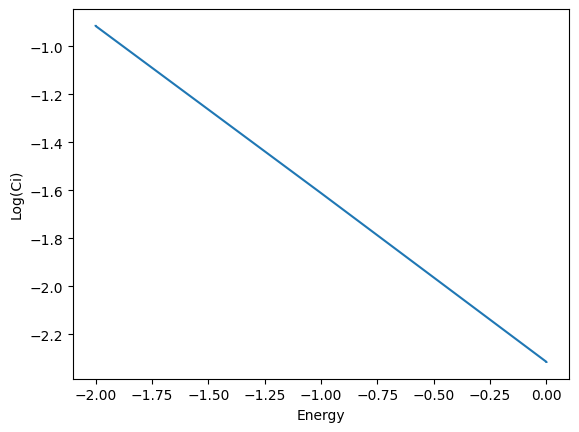

In [4]:
probs_list = []
for i in range(2**n_qubits):
    sol_string = bin(i)[2:].zfill(n_qubits)
    prob = abs(TensorOperations(pre.final_mps.tensors).proyection_state(sol_string))**2
    probs_list.append((sol_string, prob))

probs_list = sorted(probs_list, key=lambda tup: tup[1], reverse=True)

energy_x_list = []
pb_log_y_list = []
for i in range(len(probs_list)):
    
    energy_x_list.append(cost_function_max_cut.check_cost_binary(str(probs_list[i][0])))
    pb_log_y_list.append(np.log(np.sqrt(probs_list[i][1])))
    
coeficiente_pearson, valor_p = pearsonr(energy_x_list, pb_log_y_list)

print(coeficiente_pearson)



plt.plot(energy_x_list, pb_log_y_list)


plt.xlabel('Energy')
plt.ylabel('Log(Ci)')
plt.show()

In [26]:
ruta_tevo= f'logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe_vs_tevo_qaoa/case_00_tevo_qaoa_linear.json'

datos_tevo = {
    "energy_tevo": pretraining_tevo.fun_history,
    "exact_energy": exact_solution
}

json_datos_tevo = json.dumps(datos_tevo, indent=2)

with open(ruta_tevo, 'w') as archivo:
    archivo.write(json_datos_tevo)

In [ ]:
optimizer = CMA_ES(max_eval = 10000)
sampler = Sampler()


regular_qaoa_ansatz = QAOAAnsatz(n_qubits=n_qubits, layers=8, 
                                 costfunction=cost_function_max_cut, 
                                 ini_circuit = pretraining_tevo.circuit_mps)

ruta_qaoa = f'case_00_tevo_qaoa_linear_quantum.json'
logger = Logger(folder_path="logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe_vs_tevo_qaoa/", file_name= ruta_qaoa)

qaoa_tsp = QAOA(regular_qaoa_ansatz, backend, cost_function_max_cut, instance_max_cut, optimizer, sampler, n_shots=2000, logger = logger)

solution2_tsp = qaoa_tsp.solve()

# **Plot DRMG-VQE vs ITEVO-QAOA result**

In [35]:
path_data_qaoa_tevo = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe_vs_tevo_qaoa/case_0_tevo_qaoa_linear.json"
        
with open(path_data_qaoa_tevo) as f:
    
    data_tevo = json.load(f)

energy_tevo = data_tevo['energy_tevo']
exact_energy = data_tevo['exact_energy']


path_data_qaoa_tevo_quantum = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe_vs_tevo_qaoa/case_0_tevo_qaoa_linear_quantum.json"
        
with open(path_data_qaoa_tevo_quantum) as f:
    
    data_tevo_qaoa = json.load(f)

data_qaoa = [data_tevo_qaoa[i]['energy'] for i in range(len(data_tevo_qaoa))]

path_data_vqe_dmrg = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe_vs_tevo_qaoa/case_0_dmrg_vqe_linear.json"
        
with open(path_data_vqe_dmrg) as f:
    
    data_dmrg = json.load(f)

energy_dmrg = data_dmrg['energy_dmrg']
exact_energy = data_dmrg['exact_energy']


path_data_vqe_dmrg_quantum = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe_vs_tevo_qaoa/case_0_dmrg_vqe_quantum_linear.json"
        
with open(path_data_vqe_dmrg_quantum) as f:
    
    data_dmrg_vqe = json.load(f)

data_vqe = [data_dmrg_vqe[i]['energy'] for i in range(len(data_dmrg_vqe))]

/tmp/ipykernel_959464/2292745652.py:21: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, len(data_pre_dmrg_vqe))


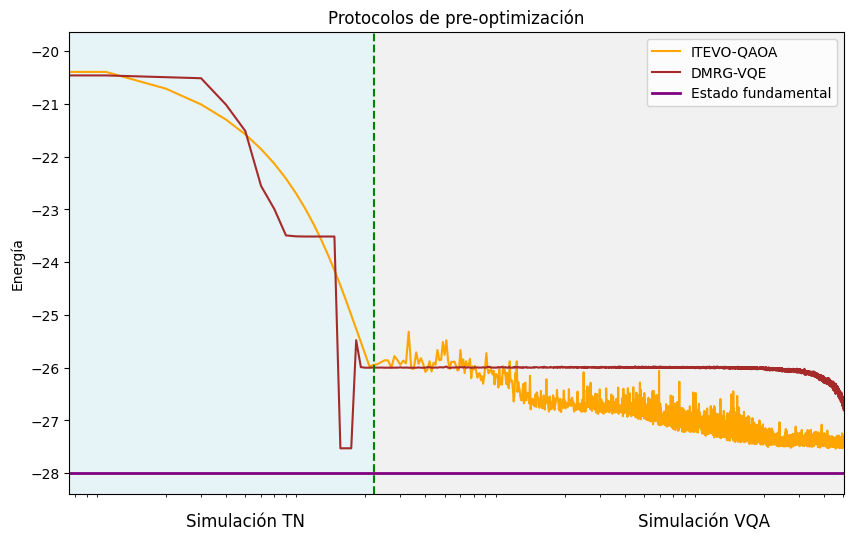

In [36]:
data_pre_tevo_qaoa = energy_tevo + data_qaoa
data_pre_dmrg_vqe = energy_dmrg + data_vqe

plt.figure(figsize=(10, 6))
plt.xscale('log')

plt.plot(range(len(data_pre_tevo_qaoa)), data_pre_tevo_qaoa, label='ITEVO-QAOA', color='orange', linestyle='-', linewidth=1.5)
plt.plot(range(len(data_pre_dmrg_vqe)), data_pre_dmrg_vqe, label='DMRG-VQE', color='brown', linestyle='-', linewidth=1.5)

plt.axvline(x=len(energy_dmrg), color='green', linestyle='--', linewidth=1.5)
plt.axhline(y=exact_energy, color='purple', linestyle='-', linewidth=2, label='Estado fundamental')

# Agregar título y etiquetas

plt.axvspan(0, len(energy_tevo), facecolor='lightblue', alpha=0.3)
plt.axvspan(22, len(data_qaoa), facecolor='lightgrey', alpha=0.3)

plt.title('Protocolos de pre-optimización')
plt.ylabel('Energía')
plt.xticks([])
plt.xlim(0, len(data_pre_dmrg_vqe))

plt.text(5, exact_energy - 1, 'Simulación TN', horizontalalignment='center', fontsize=12)
plt.text(10**3, exact_energy - 1, 'Simulación VQA', horizontalalignment='center', fontsize=12)
# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

# **Plot ITEVO-QAOA vs Random QAOA result**

In [4]:
##################################100##################################

path_data_qaoa_tevo_100 = f"logger_data/logger_data_pretraining_su4/pretraining_qaoa_with_vs_qaoa_without/case_0_tevo_qaoa_linear_t_100_dt_001.json"
        
with open(path_data_qaoa_tevo_100) as f:
    
    data_tevo_100 = json.load(f)

energy_tevo_100 = data_tevo_100['energy_tevo'][-1]
exact_energy = data_tevo_100['exact_energy']

path_data_qaoa_100 = f"logger_data/logger_data_pretraining_su4/pretraining_qaoa_with_vs_qaoa_without/case_0_tevo_qaoa_linear_quantum_t_100_dt_001.json"
        
with open(path_data_qaoa_100) as f:
    
    data_qaoa_100 = json.load(f)

data_energy_qaoa_100 = [data_qaoa_100[i]['energy'] for i in range(len(data_qaoa_100))]

##################################250##################################

path_data_qaoa_tevo_250 = f"logger_data/logger_data_pretraining_su4/pretraining_qaoa_with_vs_qaoa_without/case_0_tevo_qaoa_linear_t_250_dt_001.json"
        
with open(path_data_qaoa_tevo_250) as f:
    
    data_tevo_250 = json.load(f)

energy_tevo_250 = data_tevo_250['energy_tevo'][-1]
exact_energy = data_tevo_250['exact_energy']

path_data_qaoa_250 = f"logger_data/logger_data_pretraining_su4/pretraining_qaoa_with_vs_qaoa_without/case_0_tevo_qaoa_linear_quantum_t_250_dt_001.json"
        
with open(path_data_qaoa_250) as f:
    
    data_qaoa_250 = json.load(f)

data_energy_qaoa_250 = [data_qaoa_250[i]['energy'] for i in range(len(data_qaoa_100))]

##################################500##################################

path_data_qaoa_tevo_500 = f"logger_data/logger_data_pretraining_su4/pretraining_qaoa_with_vs_qaoa_without/case_0_tevo_qaoa_linear_t_500_dt_001.json"
        
with open(path_data_qaoa_tevo_500) as f:
    
    data_tevo_500 = json.load(f)

energy_tevo_500 = data_tevo_500['energy_tevo'][-1]

path_data_qaoa_500 = f"logger_data/logger_data_pretraining_su4/pretraining_qaoa_with_vs_qaoa_without/case_0_tevo_qaoa_linear_quantum_t_500_dt_001.json"
        
with open(path_data_qaoa_500) as f:
    
    data_qaoa_500 = json.load(f)

data_energy_qaoa_500 = [data_qaoa_500[i]['energy'] for i in range(len(data_qaoa_500))]

##################################1000##################################

path_data_qaoa_tevo_1000 = f"logger_data/logger_data_pretraining_su4/pretraining_qaoa_with_vs_qaoa_without/case_0_tevo_qaoa_linear_t_1000_dt_001.json"
        
with open(path_data_qaoa_tevo_1000) as f:
    
    data_tevo_1000 = json.load(f)

energy_tevo_1000 = data_tevo_1000['energy_tevo'][-1]

path_data_qaoa_1000 = f"logger_data/logger_data_pretraining_su4/pretraining_qaoa_with_vs_qaoa_without/case_0_tevo_qaoa_linear_quantum_t_1000_dt_001.json"
        
with open(path_data_qaoa_1000) as f:
    
    data_qaoa_1000 = json.load(f)

data_energy_qaoa_1000 = [data_qaoa_1000[i]['energy'] for i in range(len(data_qaoa_1000))]

##################################random##################################

path_data_qaoa_random= f"logger_data/logger_data_pretraining_su4/pretraining_qaoa_with_vs_qaoa_without/case_0_tevo_qaoa_linear_quantum_random.json"
        
with open(path_data_qaoa_random) as f:
    
    data_qaoa_random = json.load(f)

data_energy_qaoa_random = [data_qaoa_random[i]['energy'] for i in range(len(data_qaoa_random))]

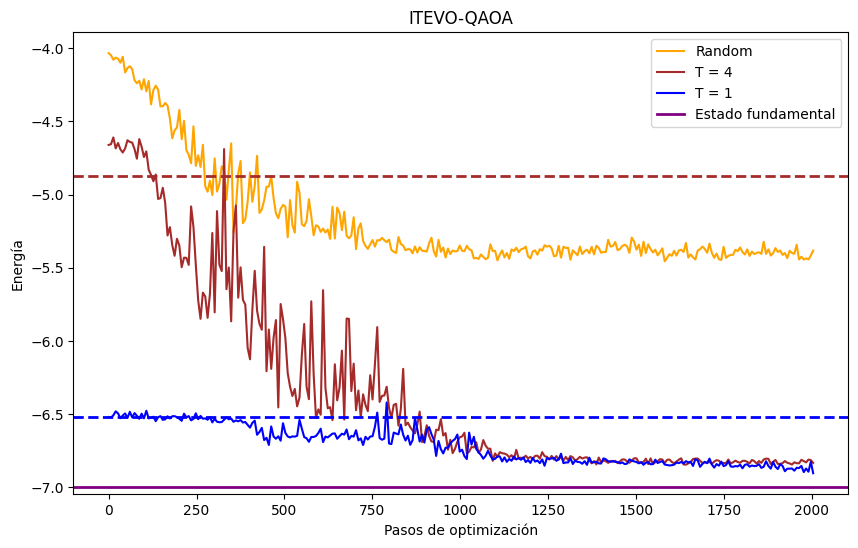

In [5]:
x = np.arange(len(data_energy_qaoa_random))
x_new = np.linspace(x.min(), x.max(), 300)

# Interpolación para suavizar las curvas
interp_random = interp1d(x, data_energy_qaoa_random, kind='cubic')
interp_250 = interp1d(x, data_energy_qaoa_250, kind='cubic')
interp_1000 = interp1d(x, data_energy_qaoa_1000, kind='cubic')

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Pintar las curvas suavizadas
plt.plot(x_new, interp_random(x_new), label='Random', color='orange', linestyle='-', linewidth=1.5)
plt.plot(x_new, interp_250(x_new), label='T = 4', color='brown', linestyle='-', linewidth=1.5)
plt.plot(x_new, interp_1000(x_new), label='T = 1', color='blue', linestyle='-', linewidth=1.5)

plt.axhline(y=energy_tevo_250, color='brown', linestyle='--', linewidth=2)
plt.axhline(y=energy_tevo_1000, color='blue', linestyle='--', linewidth=2)
plt.axhline(y=exact_energy, color='purple', linestyle='-', linewidth=2, label='Estado fundamental')

# Configuraciones adicionales del gráfico
plt.title('ITEVO-QAOA')
plt.ylabel('Energía')
plt.xlabel('Pasos de optimización')
plt.legend()
plt.show()


# **MPO Time Evolution Gibbs states**

In [2]:
n_nodes = 8

instance_max_cut = MaxCut_Instance(n_nodes)
instance_max_cut.import_from_file('logger_data/logger_data_pretraining_su4/gibbs_states_from_mpo_time_evolution/max_cut_instance_n_8_gibbs_states_for_mpo')

cost_function_max_cut = MaxCut_CostFunction(instance_max_cut)
backend = PennyLaneBackend()


n_qubits = cost_function_max_cut.num_bin_vars

exact_solution = float(instance_max_cut.brute_force()[0][2])

print('Exact solution:', exact_solution)

Exact solution: -11.0


In [3]:
energy_x_list_list_steps = []
pb_log_y_list_list_steps = []
pearson_list_steps = []

for steps in [10, 35, 70, 95]:

    pre = Pretraining(circ_class = PennyLaneQuantumCircuit, 
                    ham = cost_function_max_cut.total_hamiltonian,
                    n_qubits = n_qubits,
                    chi_mpo = 32,
                    fidelity_mps = 1.0,
                    sweeps_mps = 100,
                    init_layers_mps = 2,
                    layers_su4 = 1,
                    connectivity_su4 = 'Linear'
                    )

    pretraining_tevo = pre.time_evolution_pretraining(n_steps = steps,
                                                    dt = 0.01,
                                                    order = 2, 
                                                    init_mps = None,
                                                    metrics = True)
    
    probs_list = []
    
    for i in range(2**n_qubits):
        sol_string = bin(i)[2:].zfill(n_qubits)
        prob = abs(TensorOperations(pre.final_mps.tensors).proyection_state(sol_string))**2
        probs_list.append((sol_string, prob))

    probs_list = sorted(probs_list, key=lambda tup: tup[1], reverse=True)

    energy_x_list = []
    pb_log_y_list = []
    
    for i in range(len(probs_list)):
        
        energy_x_list.append(cost_function_max_cut.check_cost_binary(str(probs_list[i][0])))
        pb_log_y_list.append(np.log(np.sqrt(probs_list[i][1])))
    
    energy_x_list_list_steps.append(energy_x_list)
    pb_log_y_list_list_steps.append(pb_log_y_list)
    
    coeficiente_pearson, valor_p = pearsonr(energy_x_list, pb_log_y_list)
    
    pearson_list_steps.append(coeficiente_pearson)

In [4]:
energy_x_list_list_chi = []
pb_log_y_list_list_chi = []
pearson_list_chi = []

for chi in [8, 16, 32, 64]:

    pre = Pretraining(circ_class = PennyLaneQuantumCircuit, 
                    ham = cost_function_max_cut.total_hamiltonian,
                    n_qubits = n_qubits,
                    chi_mpo = chi,
                    fidelity_mps = 1.0,
                    sweeps_mps = 100,
                    init_layers_mps = 2,
                    layers_su4 = 1,
                    connectivity_su4 = 'Linear'
                    )

    pretraining_tevo = pre.time_evolution_pretraining(n_steps = 60,
                                                    dt = 0.01,
                                                    order = 2, 
                                                    init_mps = None,
                                                    metrics = True)
    
    probs_list = []
    
    for i in range(2**n_qubits):
        sol_string = bin(i)[2:].zfill(n_qubits)
        prob = abs(TensorOperations(pre.final_mps.tensors).proyection_state(sol_string))**2
        probs_list.append((sol_string, prob))

    probs_list = sorted(probs_list, key=lambda tup: tup[1], reverse=True)

    energy_x_list = []
    pb_log_y_list = []
    
    for i in range(len(probs_list)):
        
        energy_x_list.append(cost_function_max_cut.check_cost_binary(str(probs_list[i][0])))
        pb_log_y_list.append(np.log(np.sqrt(probs_list[i][1])))
    
    energy_x_list_list_chi.append(energy_x_list)
    pb_log_y_list_list_chi.append(pb_log_y_list)
    
    coeficiente_pearson, valor_p = pearsonr(energy_x_list, pb_log_y_list)
    
    pearson_list_chi.append(coeficiente_pearson)

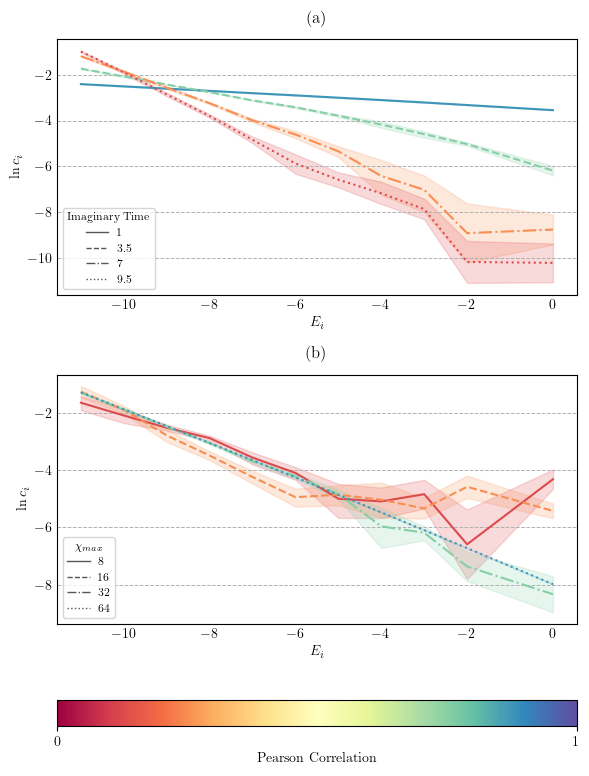

In [10]:
from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')

# Crear la figura y los ejes con gridspec para controlar la proporción de los subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12), gridspec_kw={'height_ratios': [2, 3]})

# Definir la paleta de colores
palette = sns.color_palette("Spectral", n_colors=7)
colors = [palette[6], palette[5], palette[1], palette[0]]
linestyles = ['-', '--', '-.', ':']
custom_lines = [Line2D([0], [0], color='#555555', linestyle=linestyle, linewidth=1) for linestyle in linestyles]

# Código 1
data_list = []
for i, (x, y, z) in enumerate(zip(energy_x_list_list_steps, pb_log_y_list_list_steps, pearson_list_steps), start=1):
    df_temp = pd.DataFrame({'x': x, 'y': y, 'z': z})
    df_temp['label'] = f'{i*2-1}'
    data_list.append(df_temp)

df_steps = pd.concat(data_list)

# Dibujar las líneas con colores específicos
for i in range(4):
    sns.lineplot(data=df_steps[df_steps['label'] == f'{i*2+1}'], x='x', y='y', color=colors[i], linestyle= linestyles[i], ax=ax1, label=f'{i*2+1}')

ax1.tick_params(axis='x', which='both', length=0)
ax1.tick_params(axis='y', which='both', length=0)

ax1.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=8))
ax1.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=8))

ax1.yaxis.grid(True, linestyle='--', linewidth=0.7)

ax1.set_xlabel(r'$E_i$', fontdict={'family': 'serif', 'size': 10})
ax1.set_ylabel(r'$\ln{c_i}$', fontdict={'family': 'serif', 'size': 10})
ax1.legend(handles=custom_lines, labels=[1, 3.5, 7, 9.5], title=r"Imaginary Time", title_fontproperties={'family': 'serif', 'size': 8}, prop={'family': 'serif', 'size': 8})

# Añadir etiqueta "a)" centrada sobre el primer plot
ax1.text(0.5, 1.05, '(a)', transform=ax1.transAxes, fontsize=12, fontfamily='serif',
         verticalalignment='bottom', horizontalalignment='center')

# Código 2
data_list = []
for i, (x, y, z) in enumerate(zip(energy_x_list_list_chi, pb_log_y_list_list_chi, pearson_list_chi), start=1):
    df_temp = pd.DataFrame({'x': x, 'y': y, 'z': z})
    df_temp['label'] = f'{2**i}'
    data_list.append(df_temp)

colors = [palette[0], palette[1], palette[5], palette[6]]

df_chi = pd.concat(data_list)

# Dibujar las líneas con colores específicos
for i in range(4):
    sns.lineplot(data=df_chi[df_chi['label'] == f'{2**(i+1)}'], x='x', y='y', linestyle= linestyles[i], color=colors[i], ax=ax2, label=f'{2**(i+1)}')

ax2.tick_params(axis='x', which='both', length=0)
ax2.tick_params(axis='y', which='both', length=0)

ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=8))
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True, nbins=8))

ax2.yaxis.grid(True, linestyle='--', linewidth=0.7)

ax2.set_xlabel(r'$E_i$', fontdict={'family': 'serif', 'size': 10})
ax2.set_ylabel(r'$\ln{c_i}$', fontdict={'family': 'serif', 'size': 10})
ax2.legend(handles=custom_lines, labels=[f'{2**(i+3)}' for i in range(4)], title=r"$\chi_{max}$", title_fontproperties={'family': 'serif', 'size': 8}, prop={'family': 'serif', 'size': 8}, loc='lower left')

# Añadir etiqueta "b)" centrada sobre el segundo plot
ax2.text(0.5, 1.05, '(b)', transform=ax2.transAxes, fontsize=12, fontfamily='serif',
         verticalalignment='bottom', horizontalalignment='center')

# Crear un ScalarMappable para la barra de color
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap=sns.color_palette("Spectral", as_cmap=True), norm=norm)
sm.set_array([])

# Ajustar el espacio en la parte inferior para la barra de color
fig.subplots_adjust(bottom=0.25)  # Ajustar el espacio en la parte inferior para colocar la barra de color

# Añadir la barra de color horizontal debajo del segundo subplot
cbar = fig.colorbar(sm, ax=ax2, orientation='horizontal', pad=0.2)
cbar.set_label('Pearson Correlation', fontsize=10, fontfamily='serif')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0', '1'])

# Ajustar el espacio entre los subplots para mantener la misma anchura en la figura general
plt.tight_layout(rect=[0, 0.3, 1, 0.95])  # Ajustar el rectángulo para dejar espacio a la barra de color

plt.show()


# **Performance DMRG-VQE Classic**

In [19]:
n_nodes = 14

instance_max_cut = MaxCut_Instance(n_nodes)

#instance_max_cut.random_erdos_renyi()

instance_max_cut.import_from_file('logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_instance_n_14')

#instance_max_cut.export_to_file('logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_instance_n_14')

cost_function_max_cut = MaxCut_CostFunction(instance_max_cut)


n_qubits = cost_function_max_cut.num_bin_vars

exact_solution = float(instance_max_cut.brute_force()[0][2])

print('Exact solution:', exact_solution)

Exact solution: -38.0


In [21]:
backend = PennyLaneBackend()
pre = Pretraining(circ_class = PennyLaneQuantumCircuit, 
                  ham = cost_function_max_cut.total_hamiltonian,
                  n_qubits = n_qubits,
                  chi_mpo = 2,
                  fidelity_mps = 1.0,
                  sweeps_mps = 50,
                  init_layers_mps = 2,
                  layers_su4 = 1,
                  connectivity_su4 = 'Linear'
                  )

pretraining_dmrg = pre.dmrg_pretraining(metrics= True, prep_state_dmrg = 'One_state', sweeps_dmrg = 2, lanczos_krydim = 4)

print(pretraining_dmrg)

Results:
effective_dimension: [1.999488131038454]
coherence: [0.9998153271549207] 
fun: -35.99999999999999 
fun_history: [-28.999999999999996, -29.52678360424658, -29.999983287234123, -30.499999893705322, -31.499987789185028, -31.999999890728496, -32.49999992709296, -32.999987858942696, -34.49998781960505, -34.9999878196364, -35.49997571806061, -35.49997571806091, -35.9999757207338, -35.99997572333275, -35.99997572507268, -35.99997572521139, -35.999975725211385, -35.99997572521139, -35.99997572521465, -35.99997572521616, -35.99997572521963, -35.99997572522682, -35.99997573078708, -35.99997580410192, -35.99999999974906, -35.99999999974906, -35.99999999974906, -35.999999999749065, -35.99999999974997, -35.999999999750266, -35.999999999750266, -35.99999999975027, -35.99999999975027, -35.99999999975027, -35.99999999975033, -35.99999999975032, -35.9999999997508, -36.00000000000001, -36.00000000000001, -36.00000000000001, -36.000000000000014, -36.00000000000001, -36.0, -36.0, -35.999999999999

In [23]:
ruta_dmrg= f'logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_dmrg_vqe_linear.json'

datos_dmrg = {
    "energy_dmrg": pretraining_dmrg.fun_history,
    "exact_energy": exact_solution
}

json_datos_dmrg = json.dumps(datos_dmrg, indent=2)

with open(ruta_dmrg, 'w') as archivo:
    archivo.write(json_datos_dmrg)

In [24]:
ansatz_tevo = CustomAnsatz(init_circuit = pretraining_dmrg.circuit_mps, circuit = pretraining_dmrg.circuit_su4)

ini_params = ansatz_tevo.init_params

optimizer = CMA_ES(max_eval = 1000)


sampler = Sampler()

ruta_vqe = f'case_0_max_cut_dmrg_vqe_quantum_linear.json'
logger = Logger(folder_path="logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe", file_name= ruta_vqe)

vqe = VQE(ansatz_tevo, backend, cost_function_max_cut, instance_max_cut, optimizer, sampler, logger = logger)
result_vqe_tevo = vqe.solve(ini_params)

(9_w,19)-aCMA-ES (mu_w=5.6,w_1=29%) in dimension 195 (seed=791550, Mon Aug 26 11:34:54 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     19 -3.600000000000000e+01 1.0e+00 9.74e-03  1e-02  1e-02 0:09.0
    2     38 -3.600000000000000e+01 1.0e+00 9.51e-03  1e-02  1e-02 0:18.2
    3     57 -3.600000000000000e+01 1.0e+00 9.31e-03  9e-03  9e-03 0:27.2
    4     76 -3.599800000000000e+01 1.0e+00 9.13e-03  9e-03  9e-03 0:36.1
    5     95 -3.600000000000000e+01 1.0e+00 8.98e-03  9e-03  9e-03 0:45.2
    6    114 -3.600100000000000e+01 1.0e+00 8.85e-03  9e-03  9e-03 0:54.1
    7    133 -3.600000000000000e+01 1.0e+00 8.73e-03  9e-03  9e-03 1:03.3
    8    152 -3.600000000000000e+01 1.0e+00 8.62e-03  9e-03  9e-03 1:12.1
    9    171 -3.600000000000000e+01 1.0e+00 8.52e-03  9e-03  9e-03 1:21.0
   10    190 -3.599900000000000e+01 1.0e+00 8.43e-03  8e-03  8e-03 1:37.6
   11    209 -3.600000000000000e+01 1.0e+00 8.34e-03  8e-03  8e-03 1:54.4
   12    228 -3.59980

In [57]:
N = 3
instance_tsp = TSP_Instance(N)
instance_tsp.random_uniform_distances()

#instance_tsp.export_to_file('logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_instance_n_9')


instance_tsp.import_from_file('logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_instance_n_9')

cost_function_tsp = TSP_CostFunction(instance_tsp, lagrange_multiplier=10)
n_qubits = cost_function_tsp.num_bin_vars

print(n_qubits)

energy_sol = instance_tsp.brute_force()[0][1]
print("energy_sol", energy_sol)

9
energy_sol 1.0155895885518815


In [58]:
backend = PennyLaneBackend()
pre = Pretraining(circ_class = PennyLaneQuantumCircuit, 
                  ham = cost_function_tsp.total_hamiltonian,
                  n_qubits = n_qubits,
                  chi_mpo = 2,
                  fidelity_mps = 1.0,
                  sweeps_mps = 50,
                  init_layers_mps = 2,
                  layers_su4 = 1,
                  connectivity_su4 = 'Linear'
                  )

pretraining_dmrg = pre.dmrg_pretraining(metrics= True, prep_state_dmrg = 'One_state', sweeps_dmrg = 3, lanczos_krydim = 4)

print(pretraining_dmrg)

Results:
effective_dimension: [1.0]
coherence: [-0.0] 
fun: 1.5792698603718236 
fun_history: [30.829753275943453, 45.64873079230716, 37.071598509866476, 30.897965823627953, 26.243508062560636, 21.533714341573294, 20.455771309372146, 20.225368459599345, 12.381614168523363, 12.381254524422346, 12.381254522168454, 6.907656387202927, 1.5907299347473582, 1.5794619535379653, 1.5793827205768878, 1.579382720576909, 1.5793827205768949, 1.5793827205768665, 1.5793827205768878, 1.5793827111169207, 1.5792698635299658, 1.5792698635166218, 1.579269860373401, 1.5792698603733868, 1.5792698603734152, 1.5792698603733797, 1.579269860373337, 1.5792698603733157, 1.5792698603718591, 1.5792698603719018, 1.5792698603718875, 1.5792698603719018, 1.5792698603719018, 1.5792698603718875, 1.5792698603719018, 1.579269860371916, 1.579269860371916, 1.5792698603718947, 1.5792698603718804, 1.5792698603718591, 1.5792698603719089, 1.5792698603719018, 1.5792698603718804, 1.5792698603719018, 1.5792698603719018, 1.57926986037

In [59]:
ruta_dmrg= f'logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_dmrg_vqe_linear.json'

datos_dmrg = {
    "energy_dmrg": pretraining_dmrg.fun_history,
    "exact_energy": energy_sol
}

json_datos_dmrg = json.dumps(datos_dmrg, indent=2)

with open(ruta_dmrg, 'w') as archivo:
    archivo.write(json_datos_dmrg)

In [60]:
ansatz_tevo = CustomAnsatz(init_circuit = pretraining_dmrg.circuit_mps, circuit = pretraining_dmrg.circuit_su4)

ini_params = ansatz_tevo.init_params

optimizer = CMA_ES(max_eval = 1000)


sampler = Sampler()

ruta_vqe = f'case_0_tsp_dmrg_vqe_quantum_linear.json'
logger = Logger(folder_path="logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe", file_name= ruta_vqe)

vqe = VQE(ansatz_tevo, backend, cost_function_tsp, instance_tsp, optimizer, sampler, logger = logger)
result_vqe_tevo = vqe.solve(ini_params)

(9_w,18)-aCMA-ES (mu_w=5.4,w_1=30%) in dimension 120 (seed=816396, Mon Aug 26 16:48:51 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     18 1.579269860371853e+00 1.0e+00 9.64e-03  1e-02  1e-02 0:00.7
    2     36 1.579269860371853e+00 1.0e+00 9.36e-03  9e-03  9e-03 0:01.6
    3     54 1.579269860371853e+00 1.0e+00 9.12e-03  9e-03  9e-03 0:02.6
    7    126 1.579269860371853e+00 1.0e+00 8.51e-03  8e-03  9e-03 0:05.7
   13    234 1.579269860371853e+00 1.0e+00 7.81e-03  8e-03  8e-03 0:10.5
   20    360 1.579269860371853e+00 1.1e+00 7.35e-03  7e-03  7e-03 0:15.9
   28    504 1.579269860371853e+00 1.1e+00 7.22e-03  7e-03  7e-03 0:22.4
   37    666 1.579269860371853e+00 1.1e+00 7.14e-03  7e-03  7e-03 0:29.8
   47    846 1.579269860371853e+00 1.2e+00 6.86e-03  7e-03  7e-03 0:38.1
   56   1008 1.579269860371853e+00 1.2e+00 6.77e-03  7e-03  7e-03 0:45.4
termination on maxfevals=1000 (Mon Aug 26 16:49:36 2024)
final/bestever f-value = 1.658189e+00 1.579270e+

# **Plot DRMG-VQE classic**

In [13]:
################################################## Max Cut ##################################################

path_data_qaoa_tevo = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_dmrg_vqe_linear.json"
        
with open(path_data_qaoa_tevo) as f:
    
    data_dmrg = json.load(f)

exact_energy_max_cut = data_dmrg['exact_energy']

energy_dmrg_max_cut = [abs(data_dmrg['energy_dmrg'][i] - exact_energy_max_cut)/abs(exact_energy_max_cut) for i in range(len(data_dmrg['energy_dmrg']))]

steps_dmrg_max_cut = len(energy_dmrg_max_cut)

path_data_qaoa_tevo_quantum = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_max_cut_dmrg_vqe_quantum_linear.json"
        
with open(path_data_qaoa_tevo_quantum) as f:
    
    data_tevo_vqe = json.load(f)

data_vqe_max_cut = [abs(data_tevo_vqe[i]['energy'] - exact_energy_max_cut)/abs(exact_energy_max_cut) for i in range(len(data_tevo_vqe))]

################################################## TSP ##################################################

path_data_qaoa_tevo = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_dmrg_vqe_linear.json"
        
with open(path_data_qaoa_tevo) as f:
    
    data_dmrg = json.load(f)

exact_energy_tsp = data_dmrg['exact_energy']

energy_dmrg_tsp = [abs(data_dmrg['energy_dmrg'][i] - exact_energy_tsp)/abs(exact_energy_tsp) for i in range(len(data_dmrg['energy_dmrg']))]

steps_dmrg_tsp = len(energy_dmrg_tsp)

path_data_qaoa_tevo_quantum = f"logger_data/logger_data_pretraining_su4/pretraining_dmrg_vqe/case_0_tsp_dmrg_vqe_quantum_linear.json"
        
with open(path_data_qaoa_tevo_quantum) as f:
    
    data_tevo_vqe_tsp = json.load(f)

data_vqe_tsp = [abs(data_tevo_vqe_tsp[i]['energy'] - exact_energy_tsp)/abs(exact_energy_tsp) for i in range(len(data_tevo_vqe_tsp))]

data_pre_dmrg_vqe_max_cut = energy_dmrg_max_cut[:52] + data_vqe_max_cut[:1000]
data_pre_dmrg_vqe_tsp = energy_dmrg_tsp[:52] + data_vqe_tsp[:1000]

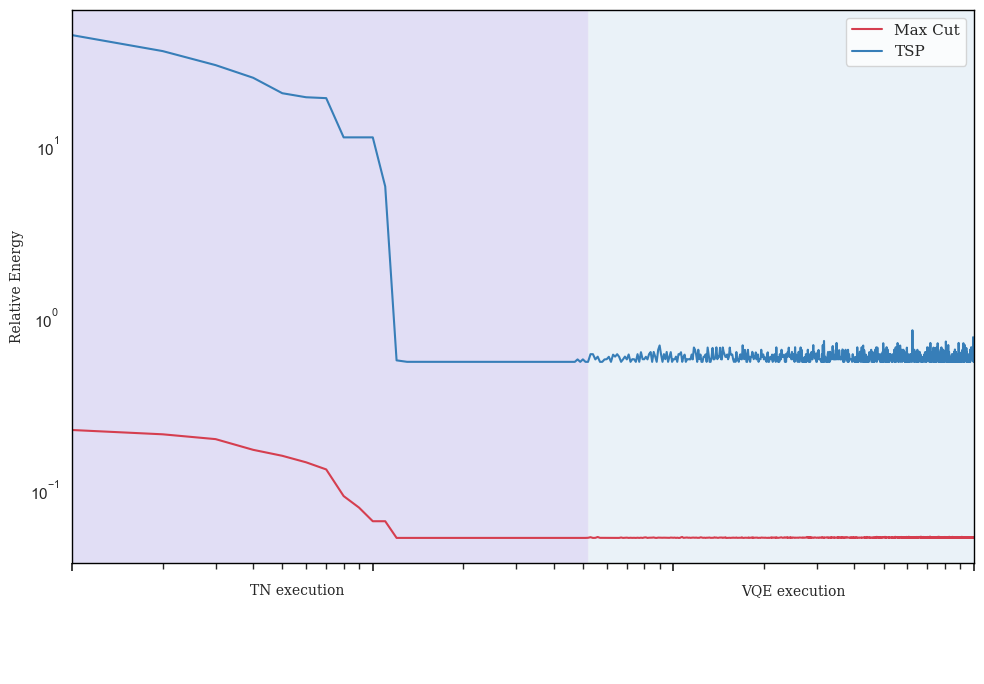

In [18]:
sns.set(style="whitegrid")

# Crear figura y subplots
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 1]}, figsize=(10, 7))

# Gráfico principal
ax1.set_xscale('log')
ax1.set_yscale('log')

# Graficar las líneas
sns.lineplot(ax=ax1, x=range(len(data_pre_dmrg_vqe_max_cut)), y=data_pre_dmrg_vqe_max_cut, label='Max Cut', color='#d53e4f', linewidth=1.5)
sns.lineplot(ax=ax1, x=range(len(data_pre_dmrg_vqe_tsp)), y=data_pre_dmrg_vqe_tsp, label='TSP', color='#377eb8', linewidth=1.5)

# Añadir líneas verticales y áreas sombreadas
#ax1.axvline(x=52, color='green', linestyle='--', linewidth=1)
ax1.axvspan(0, 52, facecolor='#6a5acd', alpha=0.2)
ax1.axvspan(52, len(data_pre_dmrg_vqe_tsp), facecolor='#3288bd', alpha=0.1)

# Configurar etiquetas y ticks
ax1.set_ylabel(r'Relative Energy', fontdict={'family': 'serif', 'size': 10})
ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False, labeltop=False)
ax1.tick_params(axis='y', which='both', bottom=True, top=False, labelbottom=False, labeltop=False)
ax1.grid(False)
ax1.set_xlim(1, 1000)

# Añadir un contorno negro a todo el plot
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)  # Ancho del borde

# Subplot inferior para las anotaciones de texto
ax2.set_xlim(1, 1000)
ax2.set_ylim(0, 1)
ax2.axis('off')  # Ocultar ejes

# Añadir anotaciones de texto
ax2.text(250, 1.5, 'TN execution', horizontalalignment='center', verticalalignment='center', fontdict={'family': 'serif', 'size': 10})
ax2.text(800, 1.5, 'VQE execution', horizontalalignment='center', verticalalignment='center', fontdict={'family': 'serif', 'size': 10})

# Configurar leyenda en el gráfico principal
ax1.legend(title_fontproperties={'family': 'serif', 'size': 8}, prop={'family': 'serif', 'size': 11})

# Mostrar el gráfico
plt.tight_layout()
plt.show()


# **Performance MPO Time Evolution-QAOA Classic**

In [2]:
N = 3
instance_tsp = TSP_Instance(N)
instance_tsp.random_uniform_distances()

#instance_tsp.export_to_file('logger_data/logger_data_pretraining_su4/pretraining_mpo_time_evolution_qaoa/case_0_tsp_instance_n_9.json')


instance_tsp.import_from_file('logger_data/logger_data_pretraining_su4/pretraining_mpo_time_evolution_qaoa/case_0_tsp_instance_n_9.json')

cost_function_tsp = TSP_CostFunction(instance_tsp, lagrange_multiplier=1)
n_qubits = cost_function_tsp.num_bin_vars

print(n_qubits)

energy_sol = instance_tsp.brute_force()[0][1]
print("energy_sol", energy_sol)

9
energy_sol 1.7286093818792319


In [12]:
backend = PennyLaneBackend()
pre = Pretraining(circ_class = PennyLaneQuantumCircuit, 
                  ham = cost_function_tsp.total_hamiltonian,
                  n_qubits = n_qubits,
                  chi_mpo = 64,
                  fidelity_mps = 1.0,
                  sweeps_mps = 200,
                  init_layers_mps = 2,
                  layers_su4 = 1,
                  connectivity_su4 = 'Linear'
                  )

pretraining_tevo = pre.time_evolution_pretraining(n_steps = 50,
                                                  dt = 0.01,
                                                  order = 2, 
                                                  init_mps = None,
                                                  metrics = True)

print(pretraining_tevo)

Results:
effective_dimension: [78.37911980248455]
coherence: [6.871010009736176] 
fun: 3.160465958278726 
fun_history: [8.199806779502714, 7.740341296516184, 7.338406652218019, 6.985131822708791, 6.6731717562314135, 6.396331800680665, 6.149456178209139, 5.928252276582039, 5.729139153740713, 5.5491206368082535, 5.385680769438763, 5.236698425471623, 5.100377847014262, 4.975192192657497, 4.859837629418049, 4.753195942306836, 4.654304019178164, 4.562328885963717, 4.476547224746498, 4.396328514827935, 4.321121104795952, 4.25044065946593, 4.1838605354537, 4.121003727736124, 4.061536100655674, 4.0051606736103125, 3.951612776842582, 3.9006559285839293, 3.8520783132226146, 3.805689762697325, 3.76131916121665, 3.71881220765313, 3.6780294813342573, 3.6388447660648193, 3.6011435945483443, 3.5648219813156565, 3.529785317121542, 3.4959474017797048, 3.463229595757616, 3.431560073692003, 3.400873165417563, 3.371108772200877, 3.342211847694613, 3.3141319347072127, 3.2868227502517353, 3.260241812512808,

-0.989326038627175
0.0


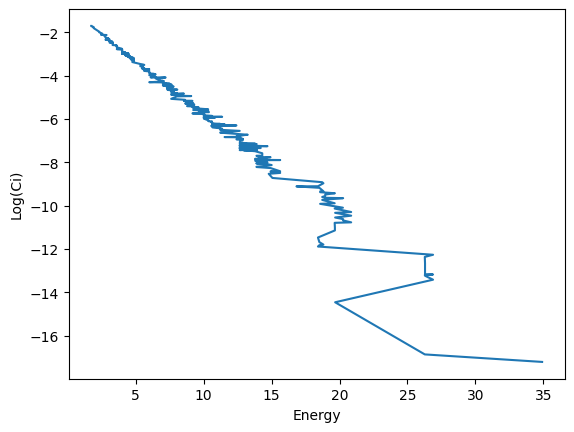

In [13]:
probs_list = []
for i in range(2**n_qubits):
    sol_string = bin(i)[2:].zfill(n_qubits)
    prob = abs(TensorOperations(pre.final_mps.tensors).proyection_state(sol_string))**2
    probs_list.append((sol_string, prob))

probs_list = sorted(probs_list, key=lambda tup: tup[1], reverse=True)

energy_x_list = []
pb_log_y_list = []
for i in range(len(probs_list)):
    
    list_path = list([int(number) for number  in str(probs_list[i][0])])

    list_path = [list_path[:3], list_path[3:6], list_path[6:]]
    
    energy = sum((sum(i) -1)**2 for i in list_path)
    
    energy_x_list.append(cost_function_tsp.get_terms_gibbs(list_path)[0] + sum(cost_function_tsp.get_terms_gibbs(list_path)[1]) + energy)
    pb_log_y_list.append(np.log(np.sqrt(probs_list[i][1])))
    
coeficiente_pearson, valor_p = pearsonr(energy_x_list, pb_log_y_list)

print(coeficiente_pearson)
print(valor_p)

plt.plot(energy_x_list, pb_log_y_list)


plt.xlabel('Energy')
plt.ylabel('Log(Ci)')
plt.show()

In [14]:
ruta_tevo= f'logger_data/logger_data_pretraining_su4/pretraining_mpo_time_evolution_qaoa/case_0_tsp_tevo_qaoa_linear_t_50_dt_01.json'

datos_tevo = {
    "energy_tevo": pretraining_tevo.fun_history,
    "exact_energy": energy_sol
}

json_datos_tevo = json.dumps(datos_tevo, indent=2)

with open(ruta_tevo, 'w') as archivo:
    archivo.write(json_datos_tevo)

In [16]:
optimizer = CMA_ES(max_eval = 2000)
sampler = Sampler()


regular_qaoa_ansatz = QAOAAnsatz(n_qubits=n_qubits, layers=5, 
                                 costfunction=cost_function_tsp)

ruta_qaoa = f'case_0_tsp_tevo_qaoa_linear_quantum_t_hadamard.json'
logger = Logger(folder_path="logger_data/logger_data_pretraining_su4/pretraining_mpo_time_evolution_qaoa/", file_name= ruta_qaoa)

qaoa_tsp = QAOA(regular_qaoa_ansatz, backend, cost_function_tsp, instance_tsp, optimizer, sampler, n_shots=2000, logger = logger)

ini_params = np.random.uniform(0, 2*np.pi, 10)

solution2_tsp = qaoa_tsp.solve(init_params = ini_params)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1001731, Fri Sep 20 19:37:54 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 8.407571066608165e+00 1.0e+00 9.03e-03  9e-03  9e-03 0:01.2
    2     20 8.502226404130898e+00 1.1e+00 8.46e-03  8e-03  9e-03 0:02.3
    3     30 8.408073515597792e+00 1.2e+00 7.85e-03  7e-03  8e-03 0:03.5
    6     60 8.375123028189002e+00 1.3e+00 6.30e-03  6e-03  6e-03 0:06.9
   10    100 8.054612842082484e+00 1.5e+00 6.84e-03  6e-03  7e-03 0:11.5
   15    150 8.207451047621268e+00 1.7e+00 5.54e-03  5e-03  6e-03 0:17.1
   19    190 8.115150462565039e+00 2.0e+00 6.39e-03  5e-03  7e-03 0:23.7
   23    230 7.942617173433931e+00 2.0e+00 5.80e-03  5e-03  7e-03 0:31.5
   28    280 8.014479716242795e+00 2.5e+00 5.66e-03  4e-03  6e-03 0:41.5
   33    330 8.093680224688235e+00 2.7e+00 6.04e-03  4e-03  7e-03 0:51.2
   39    390 8.112069865163672e+00 3.2e+00 7.36e-03  6e-03  9e-03 1:02.3
   48    480 7.971728767740204e+

# **Plot MPO Time Evolution-QAOA classic**

In [18]:
########################################## 30 ##########################################

path_data_qaoa_tevo_30 = r"C:\Users\anava\OneDrive\Escritorio\qili-lib\variational-algorithms\tfm\logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_t_30_dt_01.json"
        
with open(path_data_qaoa_tevo_30) as f:
    
    data_tevo_30 = json.load(f)

energy_tevo_30 = data_tevo_30['energy_tevo']
exact_energy = data_tevo_30['exact_energy']


path_data_qaoa_tevo_quantum_30 = r"C:\Users\anava\OneDrive\Escritorio\qili-lib\variational-algorithms\tfm\logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_quantum_t_30_dt_01.json"
        
with open(path_data_qaoa_tevo_quantum_30) as f:
    
    data_tevo_qaoa_30 = json.load(f)

data_qaoa_30 = [data_tevo_qaoa_30[i]['energy'] for i in range(len(data_tevo_qaoa_30))]


########################################## 50 ##########################################

path_data_qaoa_tevo_50 = r"C:\Users\anava\OneDrive\Escritorio\qili-lib\variational-algorithms\tfm\logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_t_50_dt_01.json"
        
with open(path_data_qaoa_tevo_50) as f:
    
    data_tevo_50 = json.load(f)

energy_tevo_50 = data_tevo_50['energy_tevo']
exact_energy = data_tevo_50['exact_energy']


path_data_qaoa_tevo_quantum_50 = r"C:\Users\anava\OneDrive\Escritorio\qili-lib\variational-algorithms\tfm\logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_quantum_t_50_dt_01.json"
        
with open(path_data_qaoa_tevo_quantum_50) as f:
    
    data_tevo_qaoa_50 = json.load(f)

data_qaoa_50 = [data_tevo_qaoa_50[i]['energy'] for i in range(len(data_tevo_qaoa_50))]



########################################## Hadamard ##########################################


path_data_qaoa_tevo_quantum_hadamard = r"C:\Users\anava\OneDrive\Escritorio\qili-lib\variational-algorithms\tfm\logger_data\logger_data_pretraining_su4\pretraining_mpo_time_evolution_qaoa\case_0_tsp_tevo_qaoa_linear_quantum_hadamard.json"
        
with open(path_data_qaoa_tevo_quantum_hadamard) as f:
    
    data_tevo_qaoa_hadamard = json.load(f)

data_qaoa_hadamard = [data_tevo_qaoa_hadamard[i]['energy'] for i in range(len(data_tevo_qaoa_hadamard))]


C:\Users\anava\AppData\Local\Temp\ipykernel_11208\618424012.py:40: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, len(data_qaoa_hadamard_smooth))


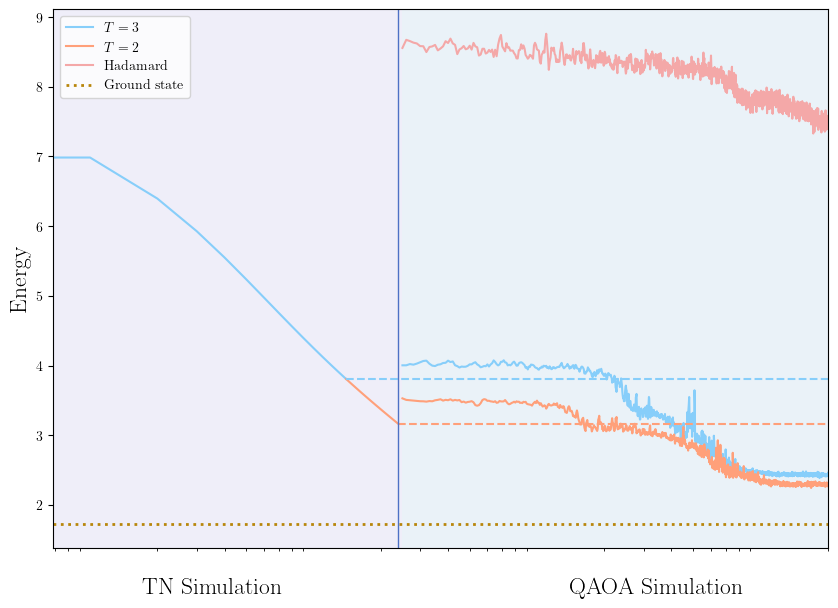

In [19]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

rc('text', usetex=True)
rc('font', family='serif')

# Suavizar los datos


energy_tevo_50_smooth = [energy_tevo_50[i] for i in range(1, len(energy_tevo_50), 2)]


data_qaoa_30_smooth = moving_average(data_qaoa_30, 
                                     window_size=3)
data_qaoa_50_smooth = moving_average(data_qaoa_50, window_size=3)
data_qaoa_hadamard_smooth = moving_average(data_qaoa_hadamard, window_size=3)

# Volver a graficar los datos suavizados
plt.figure(figsize=(10, 7))
plt.xscale('log')

# Graficar la primera parte de la línea (hasta el elemento 29)
sns.lineplot(x=range(15), y=energy_tevo_50_smooth[:15], linestyle='-', linewidth=1.5, color='#87CEFA')
sns.lineplot(x=range(14, len(energy_tevo_50_smooth)), y=energy_tevo_50_smooth[14:], linestyle='-', linewidth=1.5, color='#FFA07A')

start_point = len(energy_tevo_50_smooth)

sns.lineplot(x=range(start_point, start_point + len(data_qaoa_30_smooth)), 
             y=data_qaoa_30_smooth, label=r'$T=3$', linestyle='-', linewidth=1.5, color = '#87CEFA')

sns.lineplot(x=range(start_point, start_point + len(data_qaoa_50_smooth)), 
             y=data_qaoa_50_smooth, label=r'$T=2$', linestyle='-', linewidth=1.5, color = '#FFA07A')

sns.lineplot(x=range(start_point, start_point + len(data_qaoa_hadamard_smooth)), 
             y=data_qaoa_hadamard_smooth, label='Hadamard', linestyle='-', linewidth=1.5, color = '#F4A8A8')

plt.axvspan(0, 25, facecolor='#6a5acd', alpha=0.1)
plt.axvspan(25, len(data_qaoa_hadamard_smooth), facecolor='#3288bd', alpha=0.1)

plt.xlim(0, len(data_qaoa_hadamard_smooth)) 

plt.hlines(y=data_tevo_50['energy_tevo'][29], xmin=14, xmax=10000, colors='#87CEFA', linestyles='dashed', linewidth=1.5)
plt.hlines(y=data_tevo_50['energy_tevo'][49], xmin=24, xmax=10000, colors='#FFA07A', linestyles='dashed', linewidth=1.5)
plt.axhline(y=exact_energy, color='#B8860B', linestyle=':', linewidth=2, label='Ground state')
plt.axvline(x=24, color='#4e71c5', linestyle='-', linewidth=1)

plt.ylabel('Energy', fontsize=17)
plt.xticks([])

# Agregar texto en posiciones específicas
plt.text(3.5, exact_energy - 1, 'TN Simulation', horizontalalignment='center', fontsize=17)
plt.text(7**3, exact_energy - 1, 'QAOA Simulation', horizontalalignment='center', fontsize=17)

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()
